# Pre-processing Embryoid Body Dataset 
(available as scRNAseq.zip at Mendelay Datasets https://data.mendeley.com/datasets/v6n743h5ng/, or from "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/v6n743h5ng-1.zip")

Data follows [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices)
 
Reference procedure to clean the data: https://colab.research.google.com/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb#scrollTo=XyW3B_jOoKOS
and 
https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import shutil
import phate
import scprep
import seaborn as sns
import torch
device = torch.device("cuda:0")
print(device)

cuda:0


In [2]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import ot

In [3]:
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scanpy:", sc.__version__)

numpy: 1.26.4
pandas: 2.3.3
scanpy: 1.11.5


/tmp/ipykernel_2756258/1851518515.py:3: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("scanpy:", sc.__version__)


## Load Data + PHATE 

In [4]:
def download_and_extract_scrna():
    # Set up the download path
    download_path = "data/scRNAseq"
    os.makedirs(download_path, exist_ok=True)
    
    # Download URL
    url = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/v6n743h5ng-1.zip"
    zip_file = os.path.join(download_path, "v6n743h5ng-1.zip")
    
    print(f"Downloading from {url}...")
    urllib.request.urlretrieve(url, zip_file)
    print(f"Downloaded to {zip_file}")
    
    # Extract the outer zip file to a temp directory
    temp_extract = os.path.join(download_path, "temp_extract")
    os.makedirs(temp_extract, exist_ok=True)
    
    print("Extracting outer zip file...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(temp_extract)
    
    # Find and extract the scRNAseq.zip file
    scrna_zip = os.path.join(temp_extract, "scRNAseq.zip")
    if os.path.exists(scrna_zip):
        print("Extracting scRNAseq.zip...")
        with zipfile.ZipFile(scrna_zip, 'r') as zip_ref:
            zip_ref.extractall(temp_extract)
    
    # Move contents of scRNAseq folder to the main directory
    scrna_folder = os.path.join(temp_extract, "scRNAseq")
    if os.path.exists(scrna_folder):
        print("Moving scRNAseq contents to main directory...")
        for item in os.listdir(scrna_folder):
            src = os.path.join(scrna_folder, item)
            dst = os.path.join(download_path, item)
            shutil.move(src, dst)
            print(f"  Moved: {item}")
    
    # Clean up temp directory and zip file
    shutil.rmtree(temp_extract)
    os.remove(zip_file)
    print("Cleaned up temporary files")
    
    print(f"\nDone! scRNAseq data is in: {download_path}")
    print("\nFinal contents:")
    for item in os.listdir(download_path):
        print(f"  - {item}")

downloaded = True
if not downloaded:
    download_and_extract_scrna()

In [5]:
data_path = "data/scRNAseq"

samples = ['T0_1A', 'T2_3B', 'T4_5C', 'T6_7D', 'T8_9E']
labels = ['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']

adatas = []
for sample, label in zip(samples, labels):
    print(os.path.join(data_path, sample))
    adata = sc.read_10x_mtx(os.path.join(data_path, sample), var_names='gene_symbols', make_unique=True, cache=True)
    adata.obs['timepoint'] = label
    adatas.append(adata)

# Concatenate all samples
adata = sc.concat(adatas, merge="same")
adata.obs_names_make_unique()
print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes")

data/scRNAseq/T0_1A
data/scRNAseq/T2_3B
data/scRNAseq/T4_5C
data/scRNAseq/T6_7D
data/scRNAseq/T8_9E
Loaded 31161 cells and 33694 genes


/home/pillow/Uni/MLFG/Project/dl-uv/lib/python3.12/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
# Calculate QC metrics
## Here we are also computing quality control specific for Mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

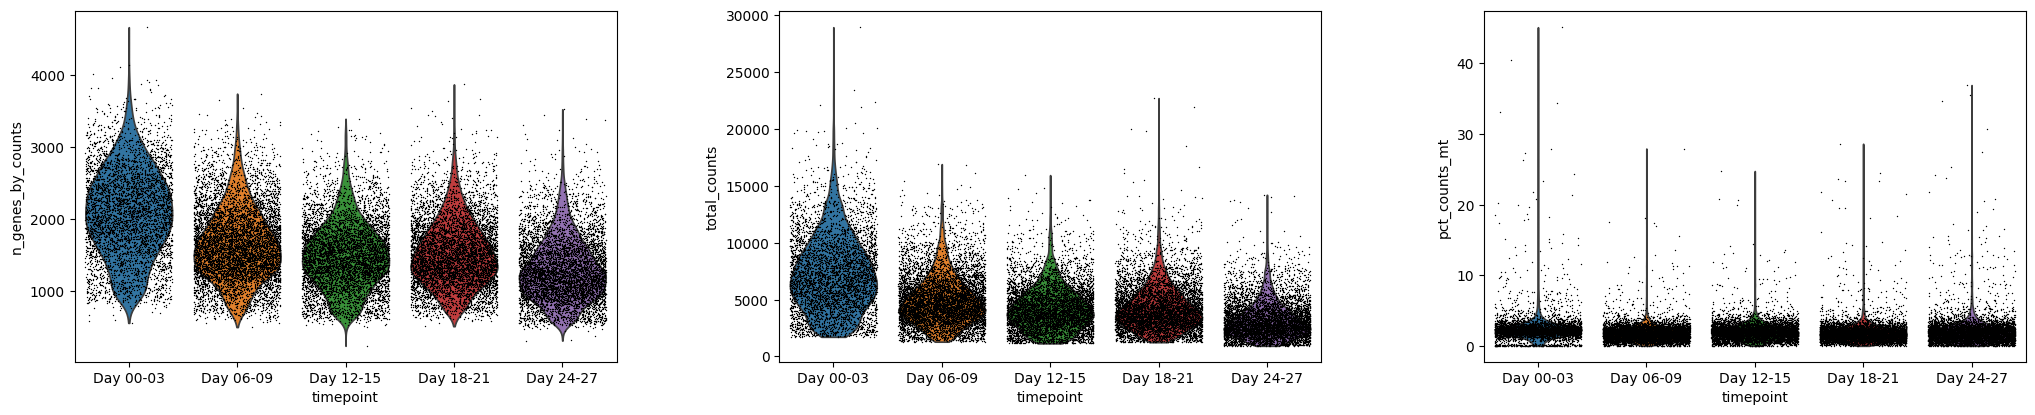

In [7]:
# Visualize QC metrics
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True, 
    groupby='timepoint'
)               

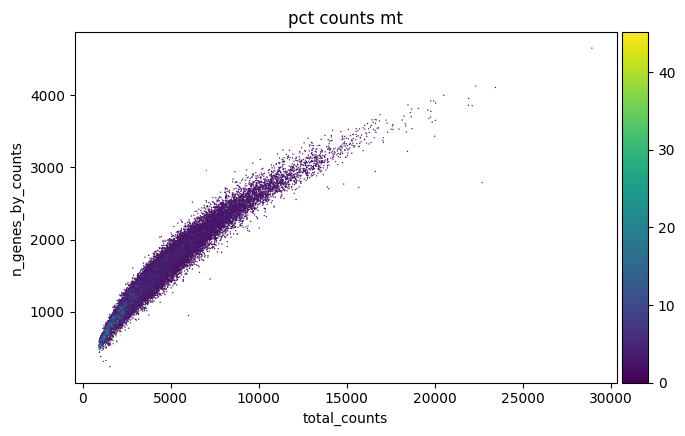

In [8]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

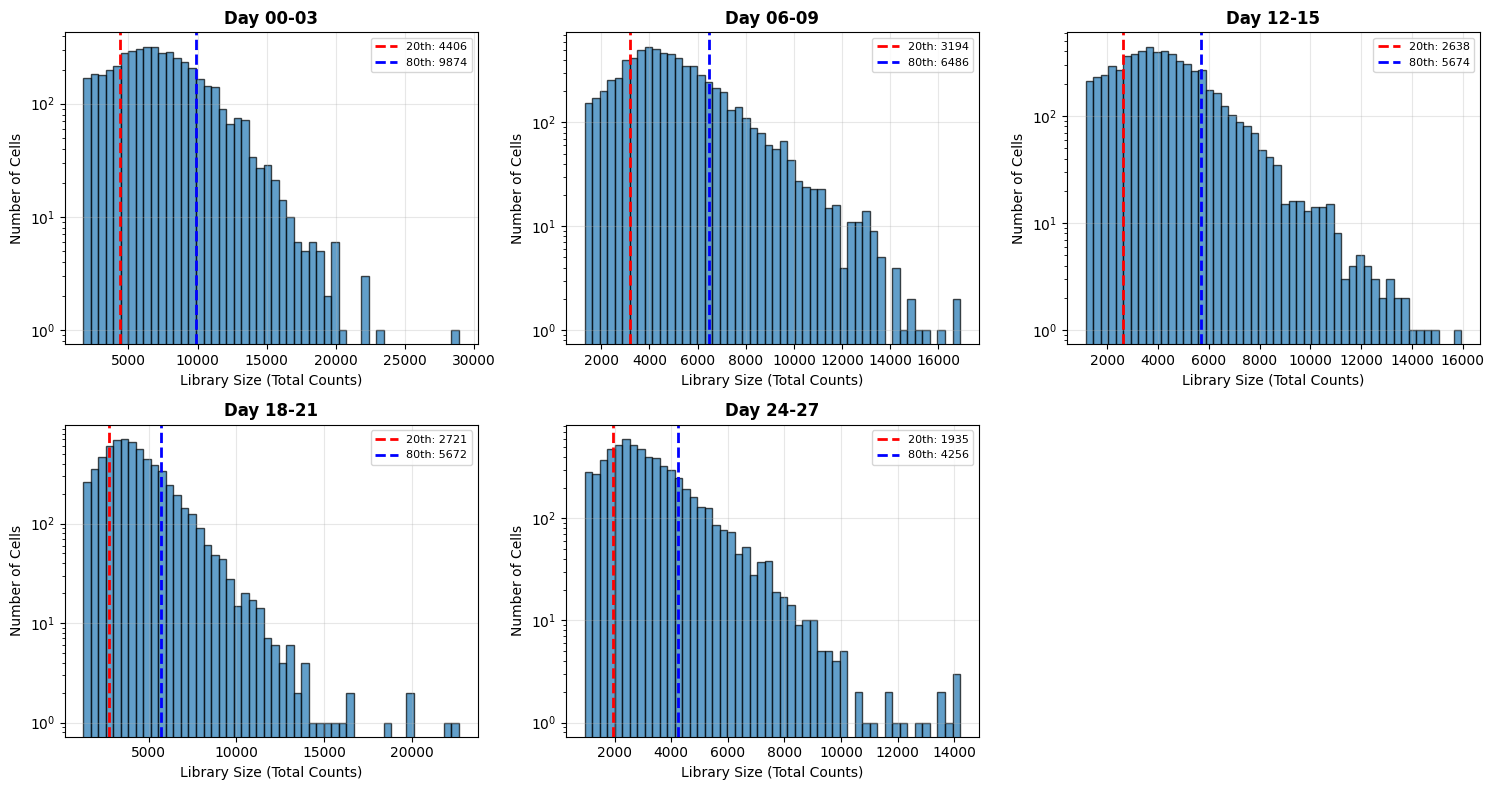

In [9]:
# Library size filtering
min_percentile = 20 # Filter cells lower than the 20th percentile
max_percentile = 80 # Filter cells higher than the 80th percentile

# Plots for each sample
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (sample, label) in enumerate(zip(samples, labels)):
    # Filter data for this sample
    sample_mask = adata.obs['timepoint'] == label
    sample_counts = adata.obs.loc[sample_mask, 'total_counts']
    
    # Calculate thresholds for this sample
    threshold_min = np.percentile(sample_counts, min_percentile)
    threshold_max = np.percentile(sample_counts, max_percentile)
    
    # Plot
    axes[idx].hist(sample_counts, bins=50, alpha=0.7, edgecolor='black', log=True)
    axes[idx].axvline(threshold_min, color='red', linestyle='--', linewidth=2,
               label=f'{min_percentile}th: {threshold_min:.0f}')
    axes[idx].axvline(threshold_max, color='blue', linestyle='--', linewidth=2,
               label=f'{max_percentile}th: {threshold_max:.0f}')
    axes[idx].set_xlabel('Library Size (Total Counts)', fontsize=10)
    axes[idx].set_ylabel('Number of Cells', fontsize=10)
    axes[idx].set_title(f'{label}', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

# Hide the extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Filter cells per sample based on library size percentiles
cells_to_keep = []

for sample, label in zip(samples, labels):
    # Get cells for this sample
    sample_mask = adata.obs['timepoint'] == label
    sample_counts = adata.obs.loc[sample_mask, 'total_counts']
    
    # Calculate thresholds for this sample
    threshold_min = np.percentile(sample_counts, min_percentile)
    threshold_max = np.percentile(sample_counts, max_percentile)
    
    # Identify cells to keep for this sample
    keep_mask = (sample_counts >= threshold_min) & (sample_counts <= threshold_max)
    cells_to_keep.extend(sample_counts[keep_mask].index.tolist())
    
    print(f"{label}: keeping {keep_mask.sum()}/{len(sample_counts)} cells "
          f"(range: {threshold_min:.0f} - {threshold_max:.0f})")
    
# Filter the AnnData object
adata = adata[cells_to_keep, :].copy()
print(f"\nTotal cells after filtering: {adata.n_obs}")

Day 00-03: keeping 2789/4649 cells (range: 4406 - 9874)
Day 06-09: keeping 4425/7377 cells (range: 3194 - 6486)
Day 12-15: keeping 3747/6245 cells (range: 2638 - 5674)
Day 18-21: keeping 3939/6563 cells (range: 2721 - 5672)
Day 24-27: keeping 3796/6327 cells (range: 1935 - 4256)

Total cells after filtering: 18696


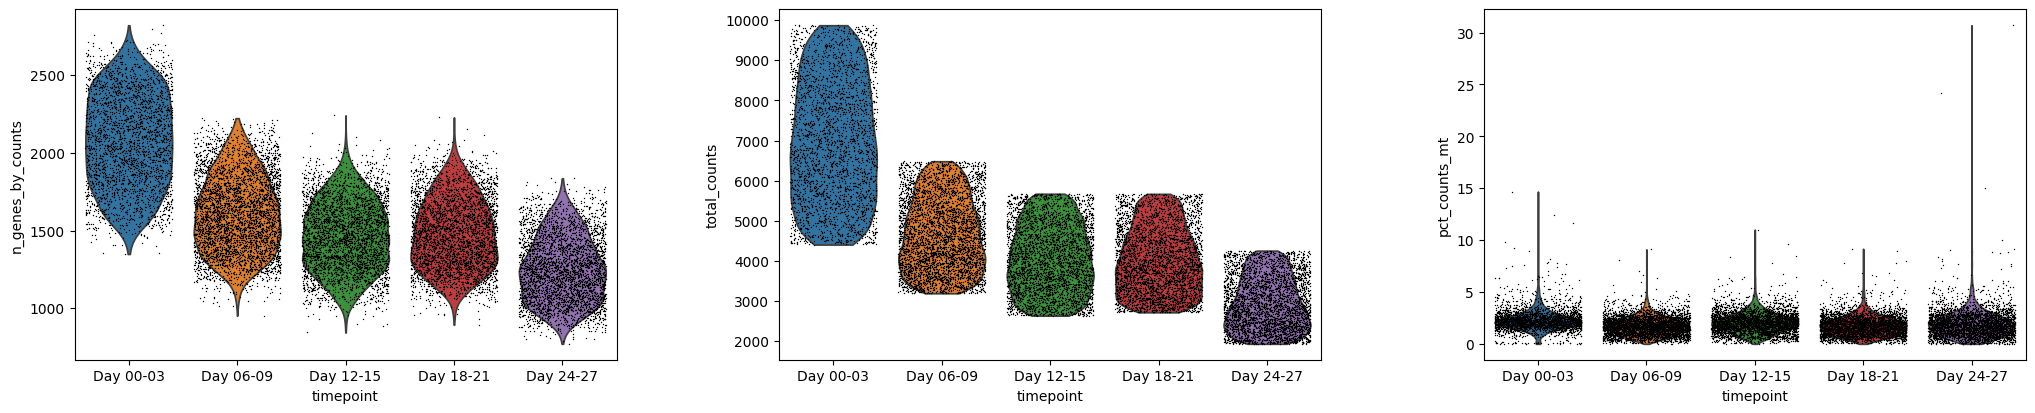

In [11]:
# Revisualizing the QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, groupby='timepoint')         

Observe that the tailes are removed

In [12]:
# removing rare genes, ones that are expressed in few of the cells
min_cells = 10
sc.pp.filter_genes(adata, min_cells=min_cells)

In [13]:
# Normalize to median library size
sc.pp.normalize_total(adata, target_sum=np.median(adata.obs['total_counts']))

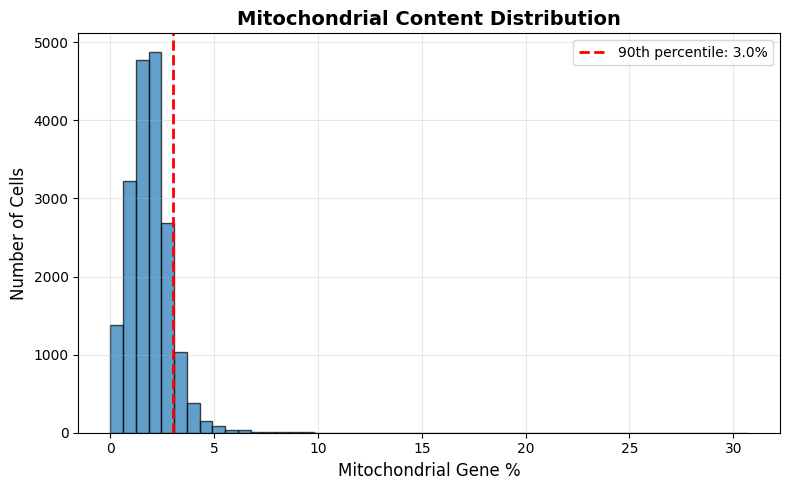

In [14]:
### renove dead cells -> have higher mitochondrial RNA expression level
# Get mitochondrial percentages
mito_pct = adata.obs['pct_counts_mt']
mito_percentile = 90
mito_threshold = np.percentile(mito_pct, mito_percentile)  # Upper percentile

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(mito_pct, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(mito_threshold, color='red', linestyle='--', linewidth=2,
           label=f'{mito_percentile}th percentile: {mito_threshold:.1f}%')
ax.set_xlabel('Mitochondrial Gene %', fontsize=12)
ax.set_ylabel('Number of Cells', fontsize=12)
ax.set_title('Mitochondrial Content Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Filter cells with high mitochondrial content
adata = adata[adata.obs['pct_counts_mt'] < mito_threshold].copy()

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [16]:
# Square root transform (alternative to log transform, stable at zero)
adata.X = np.sqrt(adata.X) # We use 

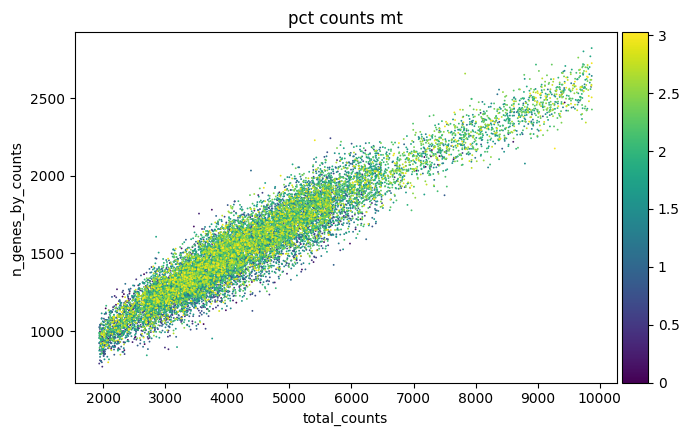

In [17]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

Perform PCA to obtain low-dimensional latent representation of each cell.

In [18]:
sc.tl.pca(adata, n_comps=30)

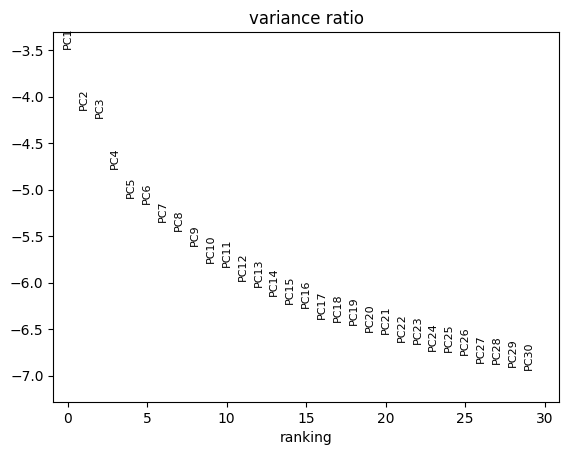

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)

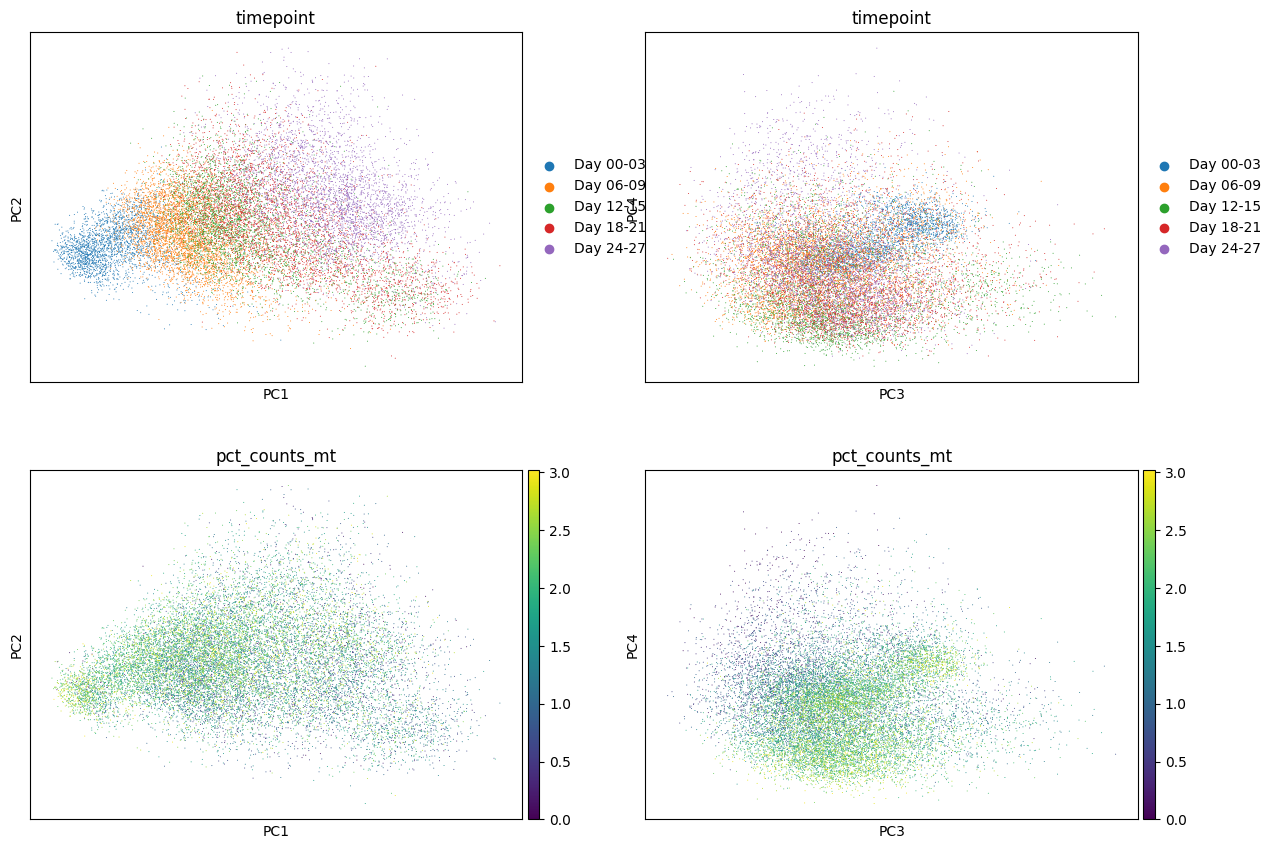

In [20]:
sc.pl.pca(
    adata,
    color=["timepoint", "timepoint", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

In [21]:
adata.obs.columns

Index(['timepoint', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt'],
      dtype='object')

In [22]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

/home/pillow/Uni/MLFG/Project/dl-uv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
sc.tl.umap(adata)

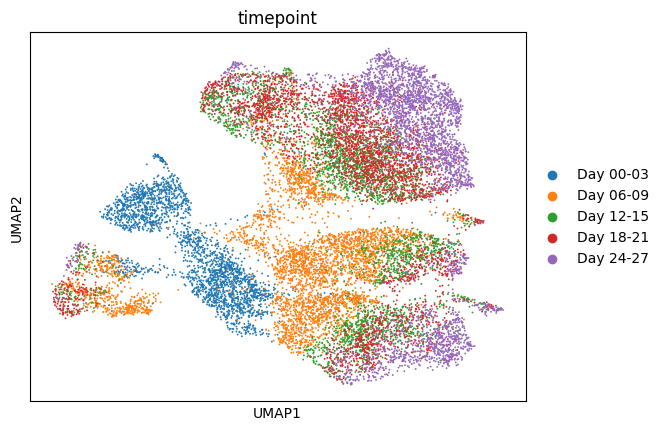

In [24]:
sc.pl.umap(adata, color="timepoint")

We observe that there is continuous progressions, and multiple branches (differentiation paths).
UMAP visualization of the latent space reveals a smooth progression of cells across developmental timepoints, with early cells concentrated near a common origin and later cells occupying multiple distinct terminal regions, consistent with branching differentiation dynamics.

In [25]:
phate_operator = phate.PHATE(n_jobs=-2,n_components=2)

X_phate = phate_operator.fit_transform(adata.obsm['X_pca'])

adata.obsm['X_phate'] = X_phate

Calculating PHATE...
  Running PHATE on 16826 observations and 30 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.51 seconds.
  Calculated graph and diffusion operator in 0.59 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.45 seconds.
    Calculating KMeans...
    Calculated KMeans in 0.80 seconds.
  Calculated landmark operator in 1.25 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 0.51 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.16 seconds.
  Calculating metric MDS...
    SGD-MDS may not have converged: stress changed by -2.7% in final iterations. Consider increasing n_iter or adjusting learning_rate.
  Calculated metric MDS in 1.19 seconds.
Calculated PHATE in 3.96 seconds.


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

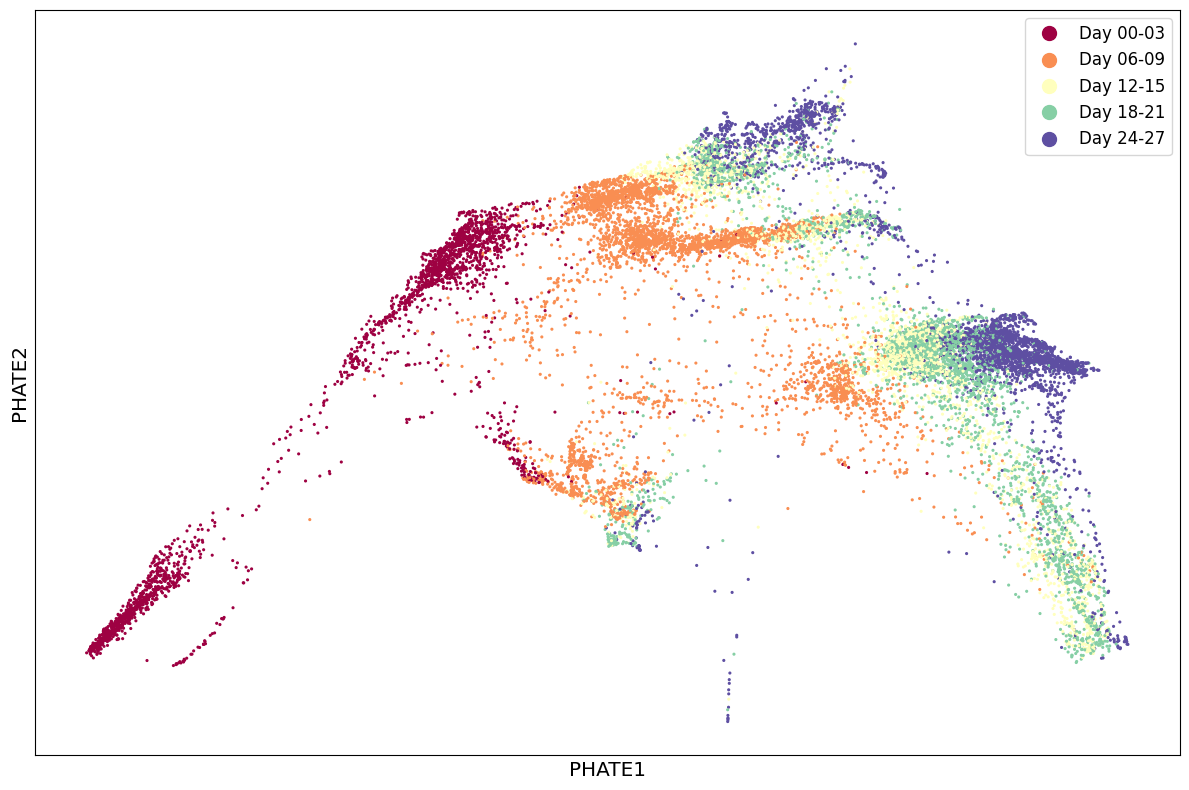

In [26]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['timepoint'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

<Axes: >

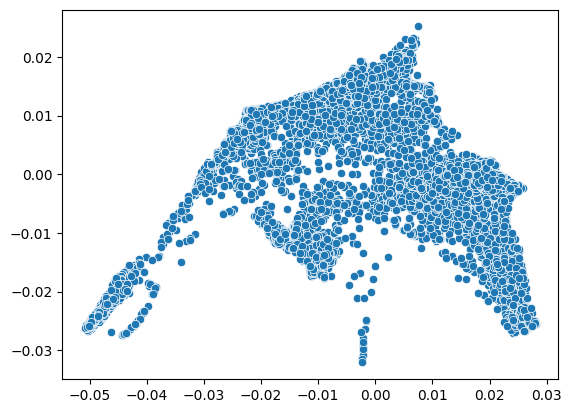

In [27]:
sns.scatterplot(x=adata.obsm['X_phate'][:,0],y=adata.obsm['X_phate'][:,1])

In [28]:
adata.obs

,timepoint,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACCGTGCAGAAA-1,Day 00-03,1581,4602.0,125.0,2.716210
AAACGCACCGGTAT-1,Day 00-03,2550,9558.0,252.0,2.636535
AAACGCACCTATTC-1,Day 00-03,2316,8084.0,224.0,2.770905
AAAGATCTCTGCTC-1,Day 00-03,1848,5463.0,132.0,2.416255
AAAGATCTGGTACT-1,Day 00-03,2350,8797.0,214.0,2.432647
...,...,...,...,...,...
TTTCGAACTTCTCA-1,Day 24-27,1132,2582.0,34.0,1.316809
TTTCTACTCTTATC-1,Day 24-27,1115,2453.0,47.0,1.916021
TTTCTACTTGAGCT-1,Day 24-27,1031,2330.0,16.0,0.686695
TTTGCATGATGACC-1,Day 24-27,927,2005.0,55.0,2.743142


In [ ]:
# save this for later 
adata.write("data/processed_scRNAseq/dataset_phate.h5ad")